In [1]:
!pip install pydriller scipy scikit-learn pandas matplotlib seaborn tqdm sentence-transformers

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [5]:
!git clone https://github.com/laude-institute/terminal-bench.git

Cloning into 'terminal-bench'...
remote: Enumerating objects: 17526, done.
remote: Counting objects: 100% (3852/3852), done.
remote: Compressing objects: 100% (1400/1400), done.
remote: Total 17526 (delta 2824), reused 2454 (delta 2452), pack-reused 13674 (from 1)
Receiving objects: 100% (17526/17526), 141.22 MiB | 20.60 MiB/s, done.
Resolving deltas: 100% (10044/10044), done.


In [6]:
import os
# --- FIX 1: STOP PARALLELISM WARNING ---
# This must be set BEFORE importing sentence_transformers or transformers
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import subprocess
import re
import math
import warnings
from io import BytesIO
from datetime import datetime

# Optional: Semantic Analysis
try:
    from sentence_transformers import SentenceTransformer
    embedder = SentenceTransformer('all-MiniLM-L6-v2')
    SEMANTIC_AVAILABLE = True
except ImportError:
    SEMANTIC_AVAILABLE = False
    print("Warning: sentence-transformers not installed. Semantic features will be skipped.")

# Suppress warnings
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")


In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import subprocess
import re
import math
import warnings
from datetime import datetime
import os

# Disable tokenizers parallelism to prevent deadlocks
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Optional: Semantic Analysis
try:
    from sentence_transformers import SentenceTransformer
    embedder = SentenceTransformer('all-MiniLM-L6-v2')
    SEMANTIC_AVAILABLE = True
except ImportError:
    SEMANTIC_AVAILABLE = False

warnings.filterwarnings('ignore')

# ==========================================
# 1. CORE UTILITIES
# ==========================================

def calculate_entropy(text):
    if not text: return 0
    counts = Counter(text)
    length = len(text)
    return -sum((count / length) * math.log2(count / length) for count in counts.values())

def dump_git_log(repo_path, start_ref="master", n_commits=None, out_file="git_log.txt"):
    cmd = [
        "git", "-C", repo_path, "log", start_ref,
        "--no-renames", "--date=iso-strict",
        # FIXED: Added %ae (email) and %cd (committer date) back for feature extraction
        "--pretty=format:__COMMIT__%h|%an|%ae|%ad|%cd|%s",
        "--numstat" 
    ]
    if n_commits: cmd.extend(["-n", str(n_commits)])

    with open(out_file, "wb") as f:
        subprocess.run(cmd, stdout=f, stderr=subprocess.PIPE, check=True)
    return out_file

def parse_git_log_file(log_path):
    with open(log_path, "r", encoding="utf-8", errors="replace") as f:
        lines = f.readlines()
    
    data = []
    current_commit = None
    
    # State tracking
    stats = {
        'lines_added': 0, 'lines_deleted': 0, 
        'test_files': 0, 'src_files': 0, 'doc_files': 0,
        'sensitive_files': 0 
    }
    
    for line in tqdm(lines, desc="Parsing Log"):
        line = line.strip()
        
        if line.startswith("__COMMIT__"):
            # 1. Save Previous Commit
            if current_commit:
                total_files = stats['test_files'] + stats['src_files'] + stats['doc_files']
                # Avoid division by zero
                safe_total = total_files if total_files > 0 else 1
                
                current_commit.update({
                    # Map to the keys expected by the Anomaly Detector
                    'lines_inserted': stats['lines_added'],
                    'lines_deleted': stats['lines_deleted'],
                    'files_changed': total_files,
                    'file_count': total_files, # Alias for consistency
                    
                    # Security Features
                    'test_ratio': stats['test_files'] / safe_total,
                    'sensitive_ratio': stats['sensitive_files'] / safe_total,
                })
                data.append(current_commit)

            # 2. Start New Commit
            parts = line.split("|")
            try:
                # Parse: %h|%an|%ae|%ad|%cd|%s
                c_hash = parts[0].replace("__COMMIT__", "")
                c_author = parts[1]
                c_email = parts[2]
                c_ad_str = parts[3]
                c_cd_str = parts[4]
                c_msg = "|".join(parts[5:])

                # Dates & Latency
                a_dt = datetime.fromisoformat(c_ad_str)
                c_dt = datetime.fromisoformat(c_cd_str)
                latency = (c_dt - a_dt).total_seconds()

                # Holiday Check
                is_holiday = 1 if (a_dt.month == 12 and a_dt.day >= 24) or (a_dt.month == 1 and a_dt.day == 1) else 0
                
                current_commit = {
                    'hash': c_hash,
                    'author': c_author,
                    'email': c_email,
                    'author_date': a_dt,
                    'hour_of_day': a_dt.hour,   # REQUIRED key
                    'day_of_week': a_dt.weekday(),
                    'merge_latency_sec': latency, # REQUIRED key
                    'is_holiday': is_holiday,
                    'msg_length': len(c_msg),     # REQUIRED key
                    'msg_entropy': calculate_entropy(c_msg), # REQUIRED key
                    'msg_content': c_msg
                }
                # Reset stats
                stats = {'lines_added': 0, 'lines_deleted': 0, 'test_files': 0, 'src_files': 0, 'doc_files': 0, 'sensitive_files': 0}
            except Exception as e:
                current_commit = None
                continue
        
        elif current_commit and line:
            # Parse numstat: "10  5   src/file.c"
            parts = line.split("\t")
            if len(parts) == 3:
                added, deleted, filepath = parts
                
                if added == '-': added = 0
                if deleted == '-': deleted = 0
                
                stats['lines_added'] += int(added)
                stats['lines_deleted'] += int(deleted)

                # Classify File Type
                if "test" in filepath.lower() or filepath.endswith(".t"):
                    stats['test_files'] += 1
                elif filepath.endswith((".c", ".h", ".cpp", ".py", ".go", ".js", ".ts")):
                    stats['src_files'] += 1
                elif filepath.endswith((".md", ".txt", ".html")):
                    stats['doc_files'] += 1
                
                if "ssl/" in filepath or "crypto/" in filepath:
                    stats['sensitive_files'] += 1

    # Don't forget the very last commit in the file!
    if current_commit:
        total_files = stats['test_files'] + stats['src_files'] + stats['doc_files']
        safe_total = total_files if total_files > 0 else 1
        current_commit.update({
            'lines_inserted': stats['lines_added'],
            'lines_deleted': stats['lines_deleted'],
            'files_changed': total_files,
            'file_count': total_files,
            'test_ratio': stats['test_files'] / safe_total,
            'sensitive_ratio': stats['sensitive_files'] / safe_total,
        })
        data.append(current_commit)

    df = pd.DataFrame(data)
    
    if df.empty: return df

    # Final Feature Engineering: Churn Ratio
    df['total_change'] = df['lines_inserted'] + df['lines_deleted']
    df['churn_ratio'] = df.apply(
        lambda row: row['total_change'] / row['files_changed'] if row['files_changed'] > 0 else 0, 
        axis=1
    )
    
    return df

# ==========================================
# 2. ML & ANALYSIS FUNCTIONS
# ==========================================

def detect_statistical_anomalies(df, contamination=0.05):
    if len(df) < 50:
        contamination = 0.1 

    # These keys MUST exist in the parsed dataframe
    features = [
        'hour_of_day', 
        'lines_inserted', 
        'lines_deleted', 
        'msg_length', 
        'msg_entropy', 
        'churn_ratio', 
        'merge_latency_sec',
        # Security / Heartbleed Features
        'is_holiday',
        'test_ratio', 
        'sensitive_ratio',
        'files_changed'
    ]
    
    # Fill NAs
    X = df[features].fillna(0)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    model = IsolationForest(contamination=contamination, random_state=42)
    df['anomaly_score'] = model.fit_predict(X_scaled)
    df['is_anomaly'] = df['anomaly_score'].apply(lambda x: True if x == -1 else False)
    
    return df

def detect_semantic_anomalies(df, repo_path):
    if not SEMANTIC_AVAILABLE or df.empty: return df

    suspects = df[df['is_anomaly'] == True].copy()
    if suspects.empty: 
        df['semantic_anomaly'] = False
        return df

    def get_diff(h):
        try:
            cmd = ["git", "-C", repo_path, "show", h, "--pretty=", "--minimal"]
            res = subprocess.run(cmd, capture_output=True, text=True, errors="replace")
            return res.stdout[:2000]
        except: return ""

    tqdm.pandas(desc="Analyzing Semantics")
    suspects['diff_content'] = suspects['hash'].progress_apply(lambda h: get_diff(h))
    
    combined_text = (suspects['msg_content'] + "\n" + suspects['diff_content']).tolist()
    embeddings = embedder.encode(combined_text)
    
    if len(embeddings) < 5:
        suspects['semantic_anomaly'] = True
    else:
        iso = IsolationForest(contamination=0.2, random_state=42)
        suspects['semantic_score'] = iso.fit_predict(embeddings)
        suspects['semantic_anomaly'] = suspects['semantic_score'] == -1
        
    df = df.merge(suspects[['hash', 'semantic_anomaly']], on='hash', how='left')
    df['semantic_anomaly'] = df['semantic_anomaly'].fillna(False)
    return df

# ==========================================
# 3. REQUESTED API FUNCTIONS
# ==========================================

def get_repo_anomaly_report(repo_path, n_commits=None, ref="master", verbose=True):
    log_file = dump_git_log(repo_path, start_ref=ref, n_commits=n_commits)
    if not log_file: return None
    
    df = parse_git_log_file(log_file)
    if df.empty: return None

    df = detect_statistical_anomalies(df)
    
    if verbose:
        df = detect_semantic_anomalies(df, repo_path)
        anomalies = df[df['is_anomaly'] == True]
        print(f"\n--- REPORT (Context: {len(df)} commits) ---")
        print(f"Detected {len(anomalies)} anomalies.")
        
    return df

def check_commit_is_anomaly(repo_path, commit_hash, n_commits=2000):
    print(f"Building context window: {n_commits} commits leading up to {commit_hash}...")
    
    df = get_repo_anomaly_report(repo_path, n_commits=n_commits, ref=commit_hash, verbose=False)
    
    if df is None or df.empty:
        print("Error: Could not retrieve history.")
        return

    target = df[df['hash'].str.startswith(commit_hash)]
    
    if target.empty:
        print(f"Critical Error: Commit {commit_hash} not found in the parsed log.")
        return

    row = target.iloc[0]
    
    print("\n" + "="*60)
    print(f"  ANOMALY CHECK: {row['hash']}")
    print("="*60)
    print(f"Author:   {row['author']} <{row['email']}>")
    print(f"Date:     {row['author_date']}")
    print(f"Message:  {row['msg_content']}")
    print("-" * 30)
    print(f"Stats:    +{row['lines_inserted']} / -{row['lines_deleted']} (Churn: {row['churn_ratio']:.2f})")
    print(f"Features: Holiday={row['is_holiday']} | TestRatio={row['test_ratio']:.2f} | SensitiveRatio={row['sensitive_ratio']:.2f}")
    print("-" * 30)
    
    if row['is_anomaly']:
        print("🔴 STATUS: ANOMALY DETECTED")
        print("   -> This commit deviates statistically from the previous history.")
    else:
        print("🟢 STATUS: NORMAL")
        print("   -> This commit fits the standard profile of this repo.")
        
    return row

Analyzing Semantics: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 57.84it/s]



--- REPORT (Context: 2000 commits) ---
Detected 100 anomalies.


,hash,author,email,author_date,hour_of_day,day_of_week,merge_latency_sec,is_holiday,msg_length,msg_entropy,...,lines_deleted,files_changed,file_count,test_ratio,sensitive_ratio,total_change,churn_ratio,anomaly_score,is_anomaly,semantic_anomaly
60,f1d03c1ace,slontis,shane.lontis@oracle.com,2025-08-27 14:24:59+10:00,14,2,6763231.0,0,23,3.849224,...,451,11,11,0.272727,0.727273,1323,120.272727,-1,True,True
117,8752f7fc02,Tomas Mraz,tomas@openssl.org,2025-10-20 16:17:38+02:00,16,0,856880.0,0,55,3.912213,...,6409,0,0,0.000000,0.000000,12809,0.000000,-1,True,False
162,ca95d136d2,Simo Sorce,simo@redhat.com,2025-10-16 15:48:09-04:00,15,3,302265.0,0,46,3.859881,...,7003,7,7,0.000000,0.000000,14079,2011.285714,-1,True,False
163,e3c5cface6,Simo Sorce,simo@redhat.com,2025-10-16 15:48:09-04:00,15,3,302265.0,0,42,3.804912,...,3628,11,11,0.545455,0.000000,7318,665.272727,-1,True,False
164,15885057f1,Simo Sorce,simo@redhat.com,2025-10-16 15:48:08-04:00,15,3,302266.0,0,41,3.877771,...,2179,6,6,0.000000,0.000000,4418,736.333333,-1,True,False


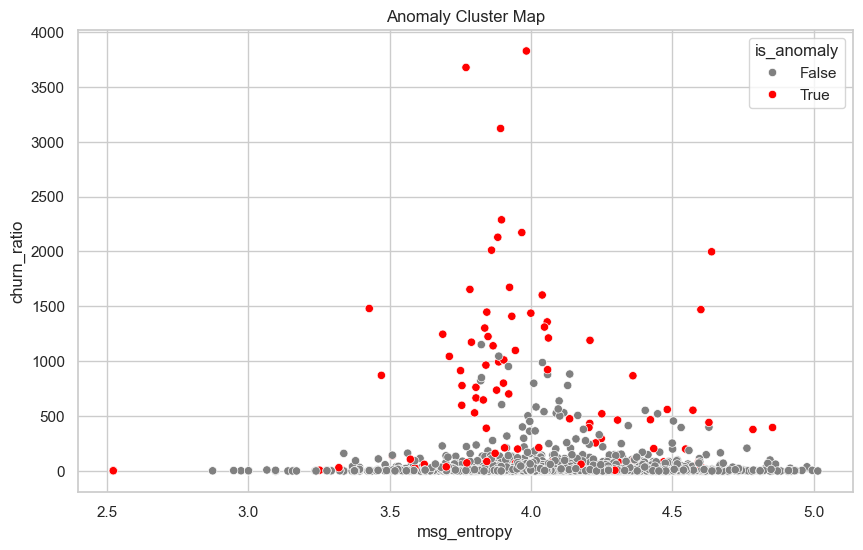

In [18]:
# Set your repo path
REPO_PATH = "./openssl" 

# Run the report
df_report = get_repo_anomaly_report(REPO_PATH, n_commits=2000, ref="master")

# Visualize the anomalies
if df_report is not None:
    anomalies = df_report[df_report['is_anomaly'] == True]
    display(anomalies.head())
    
    # Quick plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_report, x='msg_entropy', y='churn_ratio', hue='is_anomaly', palette={False:'gray', True:'red'})
    plt.title("Anomaly Cluster Map")
    plt.show()

In [52]:
df_report

,hash,author,email,author_date,merge_latency_sec,hour_of_day,day_of_week,lines_inserted,lines_deleted,files_changed,msg_length,msg_entropy,msg_content,total_change,churn_ratio,anomaly_score,is_anomaly,semantic_anomaly
2,2a7b058429,Igor Ustinov,igus68@gmail.com,2025-11-19 16:21:30+01:00,167060.0,16,2,0,0,1,92,4.076469,Correct information about the default value of...,0,0.0,1,False,False
3,768468f40e,Eugene Syromiatnikov,esyr@openssl.org,2025-11-19 15:19:59+01:00,170185.0,15,2,0,0,1,68,4.583951,doc/man3/OPENSSL_malloc.pod: mention rationale...,0,0.0,1,False,False
22,7ec28bfe45,Tomas Mraz,tomas@openssl.org,2025-11-19 12:17:18+01:00,7826.0,12,2,0,0,1,58,4.417881,80-test_cms.t: Fix regression in provider comp...,0,0.0,1,False,False
12,00b112c024,Tomas Mraz,tomas@openssl.org,2025-11-19 11:53:05+01:00,98082.0,11,2,0,0,1,56,4.094281,cms_sd.c: Code style cleanup and removed redun...,0,0.0,1,False,False
4,978cb1f9d1,Shohei YOSHIDA,syohex@gmail.com,2025-11-19 13:34:54+09:00,205063.0,13,2,0,0,1,46,4.224118,DOC: fix description of '-self_test_oninstall',0,0.0,1,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1956,45f9d271cd,Dmitry Belyavskiy,beldmit@gmail.com,2023-07-27 12:12:40+02:00,49189130.0,12,3,0,0,1,55,4.144285,Design document of using opaque object as symm...,0,0.0,1,False,False
406,2bd5e6f338,Dr. David von Oheimb,David.von.Oheimb@siemens.com,2023-03-21 14:21:45+01:00,77999299.0,14,1,0,0,2,75,4.322525,25-test_verify.t: add test for trusted root ex...,0,0.0,-1,True,True
407,dcac2c9e29,Dr. David von Oheimb,David.von.Oheimb@siemens.com,2023-02-28 12:10:35+01:00,79821569.0,12,1,0,0,2,79,3.991171,openssl-verification-options.pod: improve desc...,0,0.0,-1,True,False
408,f93fe8c471,Dr. David von Oheimb,David.von.Oheimb@siemens.com,2022-07-09 13:20:06+02:00,100038598.0,13,5,0,0,1,81,4.219299,openssl-verification-options.pod: better expla...,0,0.0,-1,True,False


In [19]:
target_hash = "4817504d06" 

result_row = check_commit_is_anomaly(REPO_PATH, target_hash, n_commits=500)

Building context window: 500 commits leading up to 4817504d06...


Parsing Log: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2146/2146 [00:00<00:00, 732680.21it/s]


  ANOMALY CHECK: 4817504d06
Author:   Dr. Stephen Henson <steve@openssl.org>
Date:     2011-12-31 22:59:57+00:00
Message:  PR: 2658 Submitted by: Robin Seggelmann <seggelmann@fh-muenster.de> Reviewed by: steve
------------------------------
Stats:    +561 / -4 (Churn: 29.74)
Features: Holiday=1 | TestRatio=0.00 | SensitiveRatio=0.84
------------------------------
🔴 STATUS: ANOMALY DETECTED
   -> This commit deviates statistically from the previous history.
